In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from datetime import datetime

from tda.client import Client
from tda.auth import easy_client
import stream.login.config as config


#create the client to talk to td ameritrade
#initialize a session
client = easy_client(
    config.API_KEY,
    config.REDIRECT_URI,
    config.TOKEN_PATH
)


In [6]:
def wol( trig_time, profit_ratio, loss_ratio, df, i):  # win or loss?  Ps the trig_price is the open price of the next minute
    # find time to start searching original df
    i = i+1
    j = i+1
    trig_price = df.iloc[i, 0]
    df = df.iloc[j:,:] 

    # compare prices
    for i,row in df.iterrows():
        # row[2] corresponds to low min price
        if row[2] >= trig_price * profit_ratio:
            return 'profit'     # indicates a sell/profit
        # row[1] corresponds to high min price
        elif row[1] <= trig_price * loss_ratio:
            return 'loss'     # indicates a sell/loss
        else:
            continue

#With the WOL function - create a comprehension that will then be used as a column to indicate win or loss

def wol_time( trig_time, profit_ratio, loss_ratio, df, i):  # win or loss?  Ps the trig_price is the open price of the next minute
    # find time to start searching original df
    i = i+1
    j = i+1
    trig_price = df.iloc[i, 0]
    df = df.iloc[j:,:] 

    # compare prices
    for i,row in df.iterrows():
        # compare to low of min row[2]
        if row[2] >= trig_price * profit_ratio:
            return (row[5] - trig_time)/60000     # indicates a sell/profit
        # compare to high of min row[1]
        elif row[1] <= trig_price * loss_ratio:
            return (row[5] - trig_time)/60000      # indicates a sell/loss
        else:
            continue

In [7]:
symbols = ['BLDP', 'ENG', 'NCLH', 'MRO', 'NNDM', 'CCL', 'FCX', 'ET', 'MARA',
       'RIOT', 'COTY', 'FTFT', 'TSLA', 'SQ', 'MGM', 'SPWR', 'SLB', 'WPRT', 'BLNK', 'FTI', 'SM', 'SUNW',
       'DDD', 'DVN', 'VUZI']
symbols = symbols[:4]
symbols = ["MGM","MARA","SLB","BLDP","SM"]
symbols = ['BLDP', 'ENG', 'NCLH', 'MRO', 'NNDM', 'CCL', 'FCX', 'ET', 'MARA',
       'RIOT', 'COTY', 'FTFT', 'TSLA', 'SQ', 'MGM', 'SPWR', 'SLB', 'WPRT', 'BLNK', 'FTI', 'SM', 'SUNW',
       'DDD', 'DVN', 'VUZI']
symbols = ["FTFT", "SUNW", "ENG", "MARA", "RESN", "SOL", "CRNT", "UAVS", "CRIS", "RRC", "RIOT", "GEVO", "BBBY", "CLXT", "FCEL", "TTM", "SRNE", "SM", "ARCT", "AR", "W", "BLDP", "CRSP", "CBAT", "OXY", "WPRT", "PEIX", "MAC", "GRWG", "SKT", "MIK", "FTI", "NVTA", "PAA", "SPWR", "X", "AMRN", "OSTK", "MGY", "DVN", "MRO", "MVIS", "SOLO", "CYH", "APA", "RUN", "MUR", "BIG", "OVV", "DPW", "VET", "EOG", "BCRX", "WKHS", "CPE", "TSLA", "FCX", "JWN", "M", "OKE", "PENN", "FUBO", "KNDI", "SLB", "NNDM", "ET", "CLF", "PBF", "PLAY", "PRTY", "BLNK", "CNK", "HAL", "AYRO", "EDIT", "CZR", "NOV", "CLSK", "KSS", "MPC", "IGT", "GT"]
symbols = ["BCS", "SEE", "VFC", "IRWD", "PBR.A", "CNQ", "ING", "PBR", "LVS", "CVE", "OUT", "KAR", "SID", "PRTS", "NOV", "XRX", "AA", "MLCO", "EDIT", "ENDP", "BTG", "AUY", "AGI", "PAAS", "EGO", "FSM", "CDE", "GBTC", "CLSK", "HL", "CRDF", "SRPT"]

symbols = ['GEVO', 'MARA', 'GME', 'RIOT','WWR', 'UAVS', 'CRNT', 'SUNW', 'MVIS', 'DDD', 'CGIX', 'BLDP', 'VUZI', 'LXRX', 'FTFT', 'RESN', 'DPW', 'MGNI', 'SYRS', 'SM', 'AQB', 'VVPR', 'SOL', 'ENG','CLSK','EDIT', 'POLA', 'SAVA', 'ALDX', 'MGI', 'GRWG', 'CRIS', 'LC', 'ARCT', 'BWEN', 'CPSH']
symbols=symbols[:4]

In [8]:
days = 10
sym_dict = []
real_roi = list()


# loop through chosen symbols
# symbols chosen by high volume and high beta
for i,symbol in enumerate(symbols):
    
    # Get the price history iteratively
    data = client.get_price_history(
        symbol, 
        period_type=Client.PriceHistory.PeriodType.DAY,
        period=Client.PriceHistory.Period.TEN_DAYS,
        frequency_type=Client.PriceHistory.FrequencyType.MINUTE,
        frequency=Client.PriceHistory.Frequency.EVERY_MINUTE)
    data = data.json()

    
    # Create dataframe with new features
    test = pd.DataFrame(data['candles'])
    test['time'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%I:%M:%S"),axis=1 )
    test['day'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%d"),axis=1 )
    test['month'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%B"),axis=1 )
    #     test['year'] = test.apply(lambda row: datetime.fromtimestamp(row.datetime/1000).strftime("%Y"),axis=1 )
    #create open to high column
    test['open_high'] = test['high']-test['open']
    #create open to low column
    test['open_low'] = test['open']-test['low']
    
    
    # Define the conditions for the trigger
    #define variables
    candle_diff = 1.2
    morn15 = ['08:{}:00'.format(30+x) for x in range(0,15)]

    # --------------------------------------------------condition for trigger-----------------------------------
    #define open higher than open low
    high_not_zero = test['open_high'] != 0 
    low_not_zero = test['open_low'] != 0 
    tall_candle = test['open_high'] > candle_diff*test['open_low']
    volume75 = test['volume'] >= np.percentile(test['volume'],[0])[0] #90
    price65th = test['open']<np.percentile(test['high'],[75])[0] #65
    #     volume75 = test['volume'] <= np.percentile(test['volume'],[10])[0] #90
    #     not_first15 = ~test['time'].isin(morn15)
    #     down_trend = past_high_mean < recent_low_mean * 1.02
    #     price35th = test['open']>np.percentile(test['high'],[45])[0]
    #     time_test = (test['time']>'08:30:00')&(test['time']<'09:00:00')

    condition = high_not_zero & low_not_zero & tall_candle & volume75 & price65th# & not_first15# & time_test & price35th & down_trend

    
    
    
    # Checking for trigger, store in trigger_df
    trigger_df = test.loc[condition, :].reset_index()

    
    
    
    #add column of desired sell prices and loss prices
    #desired roi is 0.2%
    
    
    #    _____________________________________________-    ROI    -________________________________________________
    
    roi = 0.004
    
    
    my_profit = 1+roi  #1.004
    trigger_df['to_sell_price'] = trigger_df.close * my_profit
    
    my_loss = 1-(roi*.35) #0.9986
    trigger_df['to_loss_price'] = trigger_df.close * my_loss
    
    trigger_df['wol'] = [ wol( row[6], my_profit, my_loss, test, row[0]) for i,row in trigger_df.iterrows() ]
    
    trigger_df['wol_time'] = [ wol_time( row[6], my_profit, my_loss, test, row[0]) for i,row in trigger_df.iterrows() ]
    
    
    
    print(symbol,i)
    print(trigger_df.wol.value_counts())
    
    
    profit = trigger_df.loc[trigger_df['wol']=='profit','wol'].count()
    loss = trigger_df.loc[trigger_df['wol']=='loss','wol'].count()
    
    ind_roi = round((profit*(my_profit-1))-(loss*(1-my_loss)),5)

    ind_time = trigger_df.wol_time.mean()
    #     print('Average trade time in minutes: ',ind_time)

    what_day = '15'
    
    profit_day = trigger_df.loc[(trigger_df['wol']=='profit')&(trigger_df['day']==what_day),'wol'].count()
    loss_day = trigger_df.loc[(trigger_df['wol']=='loss')&(trigger_df['day']==what_day),'wol'].count()
    
    ind_roi_day = round((profit_day*(my_profit-1))-(loss_day*(1-my_loss)),5)
    print(ind_roi_day)

    sym_data = {
        'symbol':symbol,
        'total_sells':profit,
        'total_loss':loss,
        'min_to_sell':round(ind_time,4),
        'roi_day': ind_roi_day
    }

    # append data to appropriate lists
    sym_dict.append(sym_data)
    real_roi.append((symbol, ind_roi, ind_time, trigger_df.iloc[0,4]))
    
    
#     plt.figure(figsize=(30,8))
#     sns.countplot('day', hue='wol', data=trigger_df)
#     plt.title(symbol)
#     plt.show()  
    
    
trades = pd.DataFrame.from_dict(sym_dict, orient='columns')
tradables = list()
tickers = list()
price = list()

# print(real_roi)
for x in real_roi:
    if x[2] < 10:
        tradables.append(x[1])
        tickers.append(x[0])
        price.append(x[3])

print( sum(tradables) )
print(tradables)
print(tickers)


GEVO 0
loss      670
profit    430
Name: wol, dtype: int64
0.0344
MARA 1
loss      1049
profit     825
Name: wol, dtype: int64
0.0624
GME 2
loss      708
profit    574
Name: wol, dtype: int64
0.2018
RIOT 3
loss      912
profit    666
Name: wol, dtype: int64
0.123
5.3054
[0.782, 1.8314, 1.3048, 1.3872]
['GEVO', 'MARA', 'GME', 'RIOT']


In [43]:
sym_dict

[{'symbol': 'GEVO',
  'total_sells': 430,
  'total_loss': 670,
  'min_to_sell': 7.2664,
  'roi_day': 0.0344}]

In [26]:
    
trades = pd.DataFrame.from_dict(sym_dict, orient='columns')
tradables = list()
tickers = list()
price = list()

# print(real_roi)
for x in real_roi:
    if x[2] < 3000:
        tradables.append(x[1])
        tickers.append(x[0])
        price.append(x[3])

print( sum(tradables) )
print(tradables)
print(tickers)

1.2535
[0.184, 0.4965, 0.3415, 0.3245, -0.093]
['GEVO', 'MARA', 'GME', 'RIOT', 'WWR']


In [ ]:
trades.roi_day.sum()

In [10]:
trigger_df.loc[(trigger_df['time']>'01:40:00')&(trigger_df['time']<'02:46:00')&(trigger_df['day']=='15'),:]

,index,open,high,low,close,volume,datetime,time,day,month,open_high,open_low,to_sell_price,to_loss_price,wol,wol_time
748,4495,24.9619,24.9932,24.9600,24.9781,22604,1610739660000,01:41:00,15,January,0.0313,0.0019,25.227881,24.853210,None,NaN
749,4496,24.9748,25.0000,24.9700,25.0000,14320,1610739720000,01:42:00,15,January,0.0252,0.0048,25.250000,24.875000,loss,57.0
750,4497,25.0050,25.0200,25.0010,25.0150,6696,1610739780000,01:43:00,15,January,0.0150,0.0040,25.265150,24.889925,loss,56.0
751,4498,25.0150,25.0300,25.0149,25.0169,13102,1610739840000,01:44:00,15,January,0.0150,0.0001,25.267069,24.891815,loss,55.0
752,4501,25.0350,25.0500,25.0250,25.0414,12529,1610740020000,01:47:00,15,January,0.0150,0.0100,25.291814,24.916193,loss,47.0
753,4502,25.0500,25.0700,25.0450,25.0574,12153,1610740080000,01:48:00,15,January,0.0200,0.0050,25.307974,24.932113,loss,46.0
754,4503,25.0550,25.0700,25.0500,25.0700,7342,1610740140000,01:49:00,15,January,0.0150,0.0050,25.320700,24.944650,loss,44.0
755,4510,25.0299,25.0450,25.0250,25.0350,9869,1610740560000,01:56:00,15,January,0.0151,0.0049,25.285350,24.909825,loss,41.0
756,4512,25.0300,25.0500,25.0250,25.0350,10411,1610740680000,01:58:00,15,January,0.0200,0.0050,25.285350,24.909825,loss,39.0
757,4514,25.0400,25.0550,25.0300,25.0350,6741,1610740800000,02:00:00,15,January,0.0150,0.0100,25.285350,24.909825,loss,34.0


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'FOLD')

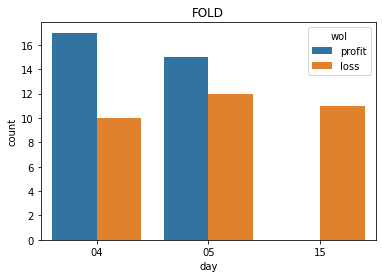

In [44]:
sns.countplot('day', hue='wol', data=trigger_df)
plt.title(symbol)

In [10]:
tradables = list()
tickers = list()
price = list()
for x in real_roi:
    if x[2] < 60 and x[3] > 2:
        tradables.append(x[1])
        tickers.append(x[0])
        price.append(x[3])

print( sum(tradables) )
print(tickers)


51.85071999999999
['FCEL', 'SRNE', 'MARA', 'RIOT', 'FUBO', 'M', 'MVIS', 'X', 'GEVO', 'SOLO', 'LXRX', 'BBBY', 'DVN', 'SPWR', 'RRC', 'SUNW', 'BLNK', 'UAVS', 'BLDP', 'WKHS', 'DPW', 'MIK', 'SABR', 'AR', 'RUN', 'CBAT', 'PBF', 'KNDI', 'BCRX', 'SM', 'CLSK', 'EDIT', 'NVTA', 'CRSP', 'PRTY', 'GRWG', 'CRIS', 'MGNI', 'VUZI', 'OSTK', 'APPS', 'SOL']


In [9]:
perc_prof = trades.loc[trades['min_to_sell']<60, :].sort_values(by='min_to_sell').total_sells.sum() * (my_profit-1)
perc_los = trades.loc[trades['min_to_sell']<60, :].sort_values(by='min_to_sell').total_loss.sum() * (1-my_loss)
perc_prof - perc_los
trades.loc[trades['min_to_sell']<600, :].sort_values(by='min_to_sell').symbol.values

array(['ENG', 'NCLH', 'BLDP', 'MRO'], dtype=object)